<a href="https://colab.research.google.com/github/lilyzhizhou/Datathon-4/blob/main/Datathon_4_N_Net_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading Packages
# importing torch as t
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import seaborn as sns
import statsmodels.api as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import warnings

warnings.filterwarnings('ignore')

import torch as t
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load in data
data = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #4/data_clean.csv')

data = data.drop('Unnamed: 0',axis = 1)

# drop apache vars
data = data.drop(['apache_4a_icu_death_prob','apache_2_diagnosis','apache_3j_diagnosis'],axis = 1)

data.head()

,hospital_death,age,gender,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,gcs_eyes_apache,gcs_motor_apache,gcs_verbal_apache
0,0,25.0,1.0,88.0,58.0,96.0,78.0,91.0,83.0,20.0,16.0,98.0,91.0,148.0,124.0,36.7,36.7,3.0,6.0,5.0
1,0,67.0,0.0,89.0,89.0,83.0,83.0,111.0,111.0,12.0,12.0,97.0,97.0,143.0,143.0,36.7,36.7,4.0,6.0,5.0
2,0,70.0,0.0,74.0,55.0,118.0,114.0,88.0,60.0,28.0,26.0,96.0,92.0,119.0,106.0,38.5,38.5,4.0,6.0,5.0
3,0,50.0,0.0,83.0,61.0,96.0,60.0,101.0,77.0,29.0,17.0,100.0,96.0,135.0,103.0,36.9,36.9,4.0,6.0,5.0
4,0,48.0,0.0,123.0,69.0,92.0,66.0,140.0,112.0,24.0,16.0,99.0,98.0,163.0,111.0,36.7,36.6,4.0,6.0,5.0


In [ ]:
# Checking for death imbalance
import plotly.express as px

# Compute the count of each class in the 'target' column
counts = data['hospital_death'].value_counts()

# Define colors for the pie chart sections
colors = ['#a3416c', '#ebc898']

# Construct a pie chart with plotly
# 'names' are the class labels, and 'values' are the counts for each class
fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # creates a donut-styled pie chart
    title='Distribution of death',
    color_discrete_sequence=colors
)

# Update the layout of the pie chart for better presentation and clarity
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='target'
    ),
    title=dict(
        text='Distribution of Classes in death',
        x=0.45,
        xanchor='center',
        y=0.95,
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

# Display the pie chart
fig.show()

Split Data into Training and Testing

---



In [4]:
# Randomly sample 70% of the data for training
train_data = data.sample(frac = .7, random_state=10)

# Use the remaining 30% for testing
test_data = data.drop(train_data.index)

# Check the mean of the 'hospital_death' column in both training and testing data
print('train', train_data['hospital_death'].mean())
print('test', test_data['hospital_death'].mean())

train 0.08613282928086606
test 0.08089414595028067


In [5]:
# Data Preparation

# Extract the 'hospital_death' column as the target variable for training and testing
Y_train = train_data['hospital_death'].to_numpy()
Y_test = test_data['hospital_death'].to_numpy()

# Extract the features (excluding 'hospital_death') for training and testing
X_train = train_data.drop('hospital_death', axis=1).to_numpy()
X_test = test_data.drop('hospital_death', axis=1).to_numpy()

Normalize Data

---



In [6]:
# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Oversampling

---



In [7]:
# Oversampling using SMOTE
from imblearn.over_sampling import SMOTENC

smote_nc = SMOTENC(categorical_features=[0,2], random_state=42)
X_train_resampled, Y_train_resampled = smote_nc.fit_resample(X_train, Y_train)

print("After OverSampling, counts of label '1': {}".format(sum(Y_train_resampled == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(Y_train_resampled == 0)))

After OverSampling, counts of label '1': 21273
After OverSampling, counts of label '0': 21273


Testing with logistic Regression

---



In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, precision_score, recall_score, f1_score

# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, accuracy, recall, precision, fi
    conf_matrix = confusion_matrix(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)
    precision = precision_score(Y_pred, Y)
    recall = recall_score(Y_pred, Y)
    f1 = f1_score(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, auc, acc, precision, recall, f1, class_report

# Define a function to print the computed scores
def print_scores(conf_matrix, auc, acc, precision, recall, f1, class_report):
    print("Confusion Matrix:")
    print(conf_matrix)
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("\nPrecision:")
    print(precision)
    print("\nRecall:")
    print(recall)
    print("\nf1-score:")
    print(f1)
    print("\nClassification Report:")
    print(class_report)


In [ ]:
# 1. Training logistic regression model
log_reg = LogisticRegression(penalty= 'none', C=0.0001, solver='lbfgs')
log_reg.fit(X_train_resampled, Y_train_resampled)

# 3.  Use the model to make predictions on the testing and training data
y_pred_test = log_reg.predict(X_test)
y_pred_train = log_reg.predict(X_train_resampled)

# 4.  Evaluate the model
conf_matrix_test, auc_test, acc_test, precision_test, recall_test, f1_test, class_report_test = get_scores(y_pred_test, Y_test)
conf_matrix_train, auc_train, acc_train, precision_train, recall_train, f1_train, class_report_train = get_scores(y_pred_train, Y_train_resampled)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, auc_train, acc_train, precision_train, recall_train, f1_train, class_report_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')

print_scores(conf_matrix_test, auc_test, acc_test, precision_test, recall_test, f1_test, class_report_test)


======== Training Set ==========
Confusion Matrix:
[[16768  5624]
 [ 4505 15649]]
AUC :  0.7626550215005762
Accuracy :  0.7619282658769332

Precision:
0.7356273210172519

Recall:
0.7764711719757864

f1-score:
0.7554976223236053

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     22392
           1       0.74      0.78      0.76     20154

    accuracy                           0.76     42546
   macro avg       0.76      0.76      0.76     42546
weighted avg       0.76      0.76      0.76     42546

======== Test Set ==========
Confusion Matrix:
[[7190  207]
 [1979  600]]
AUC :  0.6023319976664926
Accuracy :  0.7808740978348035

Precision:
0.7434944237918215

Recall:
0.23264831329972857

f1-score:
0.35440047253396334

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87      7397
           1       0.74      0.23      0.35      2579

    accurac

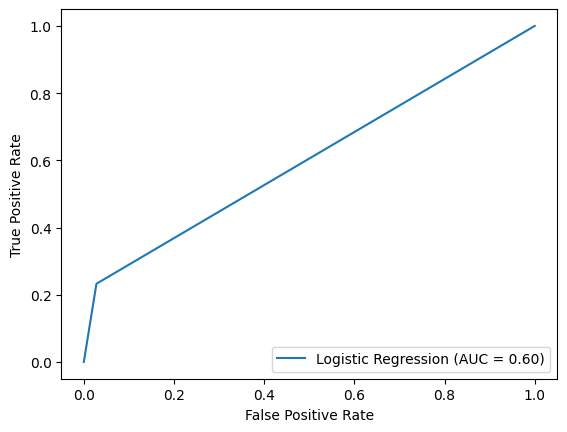

In [ ]:
# Plot the ROC curve for the test set
fpr, tpr, thresholds = roc_curve(y_pred_test, Y_test)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()

Looks like the accuracy of the test score is 0.6

Initializing Neural Network Parameters in PyTorch

In [21]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((19, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

Implementing the Forward Pass of a Neural Network in PyTorch

In [22]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with ReLU activation
    out = relu(input @ W1 + B1)

    # Second hidden layer with ReLU activation
    out = relu(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

Preparing Data and Training Utilities for Neural Network Training in PyTorch

In [23]:
# Convert the training data to PyTorch tensors
X = t.Tensor(X_train_resampled).type(t.float32)
Y = t.Tensor(Y_train_resampled).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 50

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

Training Loop for a Neural Network in PyTorch

In [24]:
train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())
        print(f'Batch {batch_idx} of {len(train_data_loader)} complete')

# Record the average loss for this epoch
train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Streaming output truncated to the last 5000 lines.
Batch 106 of 851 complete
Batch 107 of 851 complete
Batch 108 of 851 complete
Batch 109 of 851 complete
Batch 110 of 851 complete
Batch 111 of 851 complete
Batch 112 of 851 complete
Batch 113 of 851 complete
Batch 114 of 851 complete
Batch 115 of 851 complete
Batch 116 of 851 complete
Batch 117 of 851 complete
Batch 118 of 851 complete
Batch 119 of 851 complete
Batch 120 of 851 complete
Batch 121 of 851 complete
Batch 122 of 851 complete
Batch 123 of 851 complete
Batch 124 of 851 complete
Batch 125 of 851 complete
Batch 126 of 851 complete
Batch 127 of 851 complete
Batch 128 of 851 complete
Batch 129 of 851 complete
Batch 130 of 851 complete
Batch 131 of 851 complete
Batch 132 of 851 complete
Batch 133 of 851 complete
Batch 134 of 851 complete
Batch 135 of 851 complete
Batch 136 of 851 complete
Batch 137 of 851 complete
Batch 138 of 851 complete
Batch 139 of 851 complete
Batch 140 of 851 complete
Batch 141 of 851 complete
Batch 142 of 

Visualizing Training Loss Over Epochs with Matplotlib in Python

Text(0, 0.5, 'loss')

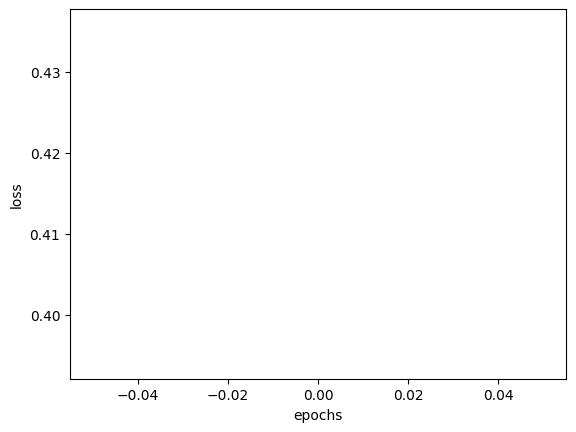

In [30]:
# Record the average loss for this epoch


# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

Evaluating Model Performance on Validation Data

In [26]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X = t.Tensor(X_train_resampled).type(t.float32)  # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train_resampled).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X)  # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y)  # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())

0.4495948553085327
0.4106239378452301


Validation model has higher loss function compared to training
- regularization will help


Regularized Training of a Neural Network in PyTorch

In [9]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from torch.nn import BCELoss

In [10]:
# Regularization

# Define hyperparameters
number_of_input_features = 19
number_of_hidden_units = 5
epochs = 150
learning_rate = 0.01
batch_size = 50
landa = 0.01  # Regularization term (lambda)
dropout_probablity = 0.6  # Probability of dropping out a neuron in dropout layer

In [11]:
# Prepare the data
X_train_tensor = t.Tensor(X_train_resampled).type(t.float32)
Y_train_tensor = t.Tensor(Y_train_resampled).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [13]:
# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),
    nn.ReLU(),
    Dropout(dropout_probablity),
    nn.Linear(number_of_hidden_units, 1),
    nn.Sigmoid()  # Assuming binary classification for the output layer
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Epoch 0/150 ---> Train Accuracy: 0.7569689154624939, Validation Accuracy: 0.7835806012153625
Epoch 1/150 ---> Train Accuracy: 0.7605650424957275, Validation Accuracy: 0.7850841879844666
Epoch 2/150 ---> Train Accuracy: 0.749424159526825, Validation Accuracy: 0.7978147268295288
Epoch 3/150 ---> Train Accuracy: 0.7505523562431335, Validation Accuracy: 0.7905974388122559
Epoch 4/150 ---> Train Accuracy: 0.75189208984375, Validation Accuracy: 0.8109462857246399
Epoch 5/150 ---> Train Accuracy: 0.7619752883911133, Validation Accuracy: 0.7696471810340881
Epoch 6/150 ---> Train Accuracy: 0.7580031156539917, Validation Accuracy: 0.7968123555183411
Epoch 7/150 ---> Train Accuracy: 0.7610586285591125, Validation Accuracy: 0.762229323387146
Epoch 8/150 ---> Train Accuracy: 0.7558407187461853, Validation Accuracy: 0.8029270172119141
Epoch 9/150 ---> Train Accuracy: 0.7609410881996155, Validation Accuracy: 0.7671411633491516
Epoch 10/150 ---> Train Accuracy: 0.7602829933166504, Validation Accuracy:

In [20]:
 # Calculate average accuracy
import statistics

print("train accuracy", statistics.mean(train_accuracy_list))
print("validation accuracy", statistics.mean(validation_accuracy_list))

train accuracy 0.7575201733907064
validation accuracy 0.7843998928864797


Text(0, 0.5, 'Accuracy')

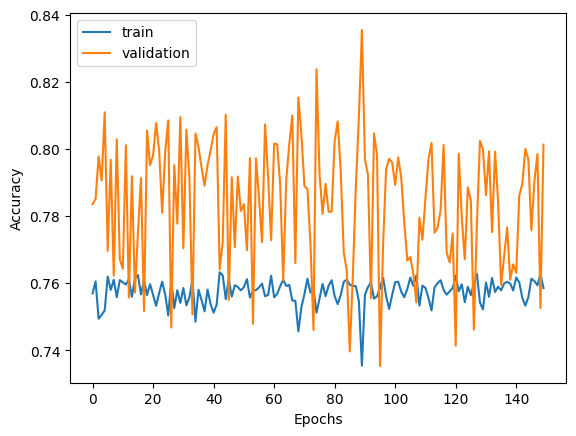

In [14]:
# Plotting the training and validation accuracy
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')